In [2]:
import pandas as pd
from IPython.display import Javascript
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
%matplotlib inline


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dark_blue = "#263f96"
light_blue= '#43B0F1'
lighter_blue = '#c8d9ed'
light_red= '#D43790'
light_orange = '#F79862'
red ='#EA1313'

pd.set_option('precision', 4)

params = {'legend.fontsize': 'x-large',          
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#'figure.figsize': (28,11),         
pd.set_option('display.max_rows', 200)         
plt.rcParams.update(params)

lm_names = ['(1) STJ','(2) PAB','(3) 1st SAV','(4) 3rd SAV']
exp_desc = {0:['7x7ms4','5x5'],1:['5x5','6x6','7x7','8x8'],2:['5x5'],3:['5x5']}

num = 1 # Landmark number
indx = 3 # Number of try
windowsize = 10
centered = True
filepath = f'/content/drive/My Drive/TFM/Data_models_TFM/AORTA/{indx:02d}_SA_0{num}/'
filename = 'stats.json'

print(filepath+filename)
data = pd.read_json(path_or_buf= filepath+filename,orient='records') 

my_df = data[['epoch_num','n_success_ratio','mean_score','mean_distance','max_distance','global_step',
              'expreplay/mean_score',	'expreplay/max_score',	'expreplay/mean_dist',	'expreplay/max_dist','huber_loss/value','QueueInput/queue_size']].copy()
my_df['weighted_value'] = my_df.apply(lambda row: \
                                      100*row.n_success_ratio**2*row.mean_score/((row.mean_distance)*(row.max_distance)), axis=1)
# my_df['weighted_value'] = my_df.apply(lambda row: \
#                                      100*row.n_success_ratio**3*row.mean_score/((row.mean_distance*row.iloc[8])*(row.max_distance*row.iloc[9]**0.5)), axis=1)

my_df['rolling_w_v'] = my_df['weighted_value'].rolling(window=windowsize, min_periods=windowsize//2,center=centered).mean()
my_df.set_index('epoch_num')
my_df.tail(10)

/content/drive/My Drive/TFM/Data_models_TFM/AORTA/03_SA_01/stats.json


,epoch_num,n_success_ratio,mean_score,mean_distance,max_distance,global_step,expreplay/mean_score,expreplay/max_score,expreplay/mean_dist,expreplay/max_dist,huber_loss/value,QueueInput/queue_size,weighted_value,rolling_w_v
84,85,0.9811,NaN,NaN,NaN,2125000,51.9544,96.2818,1.6337,117.1793,0.0648,0.1958,NaN,4229.4224
85,86,0.9806,43.9921,1.0000,1.0000,2150000,52.5230,93.7222,1.4957,109.4029,0.0676,0.5715,4230.3775,4167.2449
86,87,0.9824,NaN,NaN,NaN,2175000,52.7386,103.9376,1.4911,111.0045,0.7370,1.0672,NaN,4167.2449
87,88,0.9800,48.5528,1.0331,1.4142,2200000,52.9631,96.0606,1.5951,121.4166,0.0807,1.5284,3191.1763,3774.5221
88,89,0.9822,NaN,NaN,NaN,2225000,52.6494,103.7948,1.5593,117.6095,0.0719,0.5686,NaN,3774.5221
89,90,0.9827,47.2914,1.0000,1.0000,2250000,52.7782,96.5151,1.5185,118.7182,0.0694,0.6017,4567.3016,3781.9255
90,91,0.9829,NaN,NaN,NaN,2275000,52.8676,94.6667,1.5285,106.1508,0.0704,0.4068,NaN,3781.9255
91,92,0.9810,46.4587,1.0873,1.7321,2300000,52.4099,99.0235,1.5813,109.4075,0.0753,0.5266,2374.2736,NaN
92,93,0.9818,NaN,NaN,NaN,2325000,52.5345,104.3515,1.5524,111.1485,0.0855,0.5265,NaN,NaN
93,94,0.9831,47.0401,1.0000,1.0000,2350000,52.7767,97.0736,1.5021,125.2238,0.0685,0.4121,4546.4987,NaN


<IPython.core.display.Javascript object>

Current best: 03_rlsa_01_model-2000000.0.txt


,epoch_num,n_success_ratio,mean_score,mean_distance,max_distance,global_step,expreplay/mean_score,expreplay/max_score,expreplay/mean_dist,expreplay/max_dist,huber_loss/value,QueueInput/queue_size,weighted_value,rolling_w_v
79,80,0.9831,50.4785,1.0000,1.0000,2000000,52.4485,103.2140,1.5900,120.1416,0.0797,0.2560,4878.1890,4252.5617
67,68,0.9838,47.4144,1.0000,1.0000,1700000,51.8457,102.2607,1.5258,117.7243,0.0813,0.3771,4588.8958,4208.9173
89,90,0.9827,47.2914,1.0000,1.0000,2250000,52.7782,96.5151,1.5185,118.7182,0.0694,0.6017,4567.3016,3781.9255
93,94,0.9831,47.0401,1.0000,1.0000,2350000,52.7767,97.0736,1.5021,125.2238,0.0685,0.4121,4546.4987,NaN
35,36,0.9641,47.4623,1.0000,1.0000,900000,51.5628,101.2679,1.9323,148.5160,0.0874,0.1461,4411.8993,2696.6885
51,52,0.9605,42.2273,0.6366,1.4142,1300000,51.3359,98.0989,1.8206,130.1998,0.0845,0.2985,4327.3177,2763.5769
45,46,0.9469,43.3363,1.0000,1.0000,1150000,51.6756,99.3224,2.0135,117.4989,0.0935,0.3135,3885.7979,2819.5843
29,30,0.9526,44.7986,1.1823,1.4142,750000,51.1466,93.4181,1.9977,125.3515,0.1116,0.1957,2431.4979,2258.9809
19,20,0.9276,40.9991,1.1515,3.6056,500000,49.8564,98.5860,2.4854,119.7873,0.0878,1.1480,849.6885,972.1633
9,10,0.6195,42.2910,1.9079,2.4495,250000,47.2123,99.1740,4.1723,129.7498,0.0920,50.0000,347.2354,229.3079


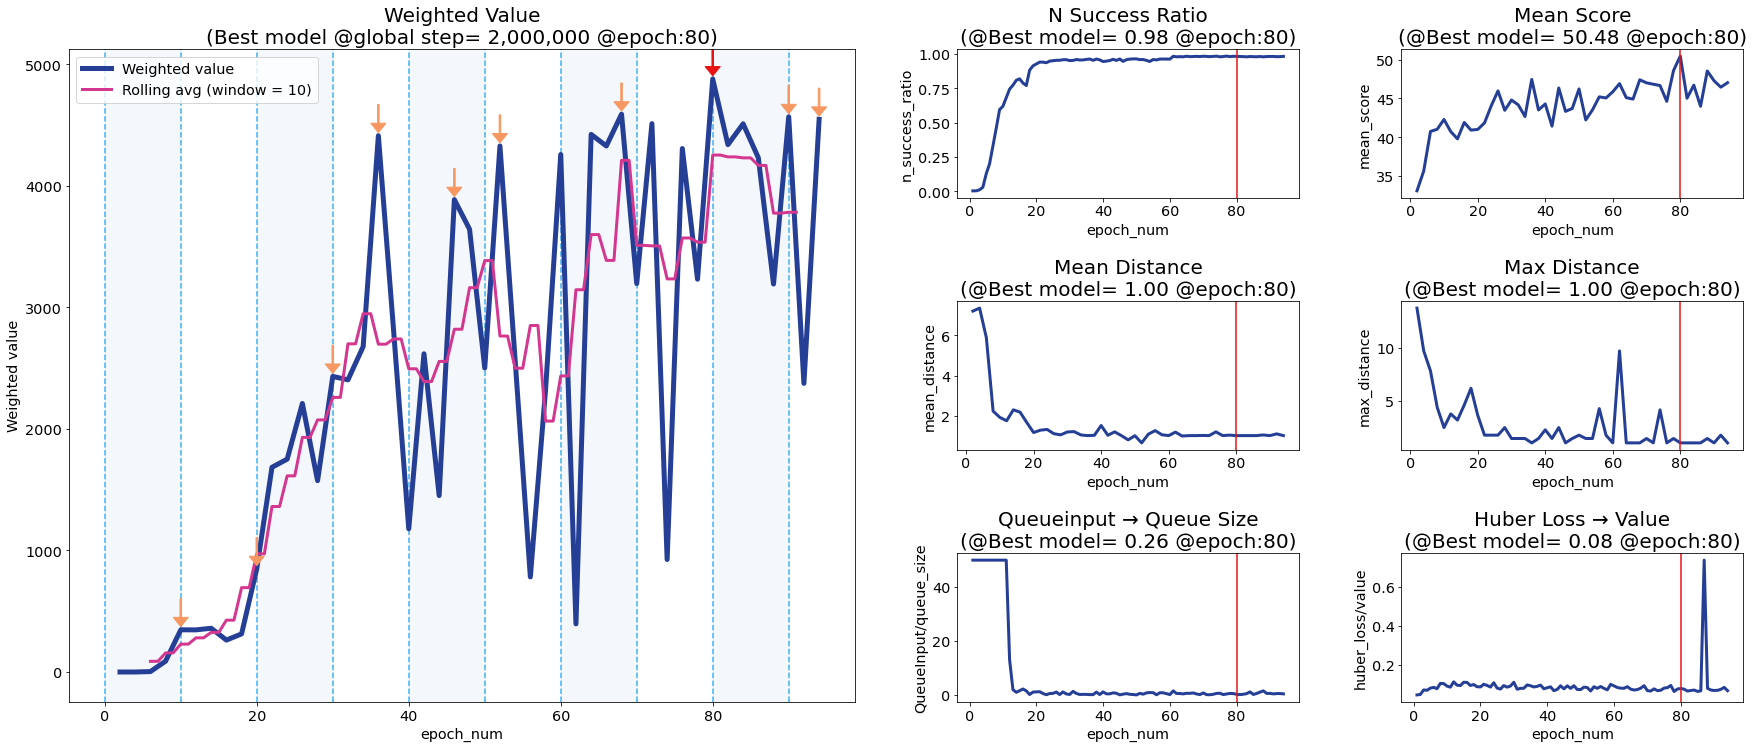

In [4]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

#Setting the subplot
fig = plt.figure(figsize = (30,12))
grid = plt.GridSpec(3, 4, hspace=.7, wspace=0.3)
arrow_symb = " "+u"\u2192"+" " 
multiax = fig.add_subplot(grid[:, :2])
ax1 = fig.add_subplot(grid[0, 2])
ax2 = fig.add_subplot(grid[0, 3])
ax3 = fig.add_subplot(grid[1, 2])
ax4 = fig.add_subplot(grid[1, 3])
ax5 = fig.add_subplot(grid[2, 2])
ax6 = fig.add_subplot(grid[2, 3])

best_mod = my_df.iloc[my_df['weighted_value'].argmax(),:] #choose best model 
columns_to_plot = ["weighted_value","n_success_ratio" ,"mean_score","mean_distance","max_distance",'QueueInput/queue_size',"huber_loss/value"]
group_of_best = []
current_max = np.NINF

for i, ax in enumerate(plt.gcf().get_axes()):
  if i == 0: # first plot is different
    n_group=10
    df_max = my_df.groupby(np.arange(len(my_df.index)) // n_group)[['weighted_value']].agg(['min', 'max','idxmax'])#group i
    if len(my_df)%n_group == 1:
      df_max.drop(df_max.tail(1).index,inplace=True)
      df_max.iloc[:,2] = df_max.iloc[:,2].astype('int64')
          
    wgth = sns.lineplot(x="epoch_num", y=columns_to_plot[i], data=my_df,ax= ax,color = dark_blue, zorder = -5, linewidth = 5,label = f'Weighted value')
    mvavg = sns.lineplot(x="epoch_num", y="rolling_w_v", data=my_df,ax= ax,
             color = light_red,linewidth = 3, zorder = -4,linestyle ='--',
             label =f'Rolling avg (window = {windowsize})').set_title(f"Weighted Value\n(Best model @global step= {best_mod.global_step:,.0f} @epoch:{best_mod.epoch_num:.0f})", fontsize=20)
    ax.set(ylabel='Weighted value')

    for id_now, max_index in enumerate(df_max.iloc[:,2]):

      if my_df.weighted_value[max_index] > 0.85*current_max:
      #if my_df.weighted_value[max_index] > 1.1*my_df.rolling_w_v[max_index]:
        
        group_of_best.append(max_index)

        offset = .05*ax.get_ylim()[1]
        if max_index != my_df['weighted_value'].idxmax():
          arrow_reg = ax.arrow(max_index+1, my_df.weighted_value[max_index]+offset, 0,-offset*0.9,
                          fc=light_orange, ec=light_orange, alpha=1, width=.2,label='Region maximum',
                          head_width=2, head_length=offset*0.3,zorder = -3,overhang = 0,length_includes_head = True)
        else:
          arrow_max = ax.arrow(max_index+1, my_df.weighted_value[max_index]+offset, 0,-offset*0.9,
                           fc=red, ec=red, alpha=1, width=.2,head_width=2,label='Global maximum', 
                           head_length=offset*0.3,zorder = -3,overhang = 0,length_includes_head = True)
      
      current_max = my_df.weighted_value[max_index]

      if id_now%2 != 1:
        mythresh =  (max_index//n_group)*n_group
        ax.axvline(mythresh,color=light_blue,linestyle ='--',linewidth = 1.5,zorder = -8)
        ax.axvline(mythresh + n_group,color=light_blue,linestyle ='--',linewidth = 1.5,zorder = -8)
        ax.axvspan( mythresh,mythresh + n_group, color= lighter_blue, alpha = 0.2,zorder = -10)
        
  else:
    sns.lineplot(x="epoch_num", y=columns_to_plot[i]  ,data=my_df,ax=ax,
              color = dark_blue,
              linewidth = 3).set_title(f'{columns_to_plot[i].replace("_", " ").replace("/",arrow_symb).title()}\n(@Best model= {best_mod.loc[columns_to_plot[i]]:.2f} @epoch:{best_mod.epoch_num:.0f})', fontsize=20)  
    ax.axvline(best_mod.epoch_num,color=red,linewidth = 1.5)

multiax.legend()
best_name = f"{indx:02d}_rlsa_0{num}_model-{my_df.iloc[my_df['weighted_value'].idxmax,:].global_step.item()}.txt"
best_reg_names = [f"{indx:02d}_rlsa_0{num}_model-{my_df.iloc[reg_ind,:].global_step.item():.0f}.txt" for reg_ind in group_of_best ]
print(f'Current best: {best_name}')
my_df.iloc[group_of_best].sort_values(by='weighted_value',ascending=False)


In [5]:
best_reg_names

['03_rlsa_01_model-250000.txt',
 '03_rlsa_01_model-500000.txt',
 '03_rlsa_01_model-750000.txt',
 '03_rlsa_01_model-900000.txt',
 '03_rlsa_01_model-1150000.txt',
 '03_rlsa_01_model-1300000.txt',
 '03_rlsa_01_model-1700000.txt',
 '03_rlsa_01_model-2000000.txt',
 '03_rlsa_01_model-2250000.txt',
 '03_rlsa_01_model-2350000.txt']

## Validation results of the different models chosen from training:

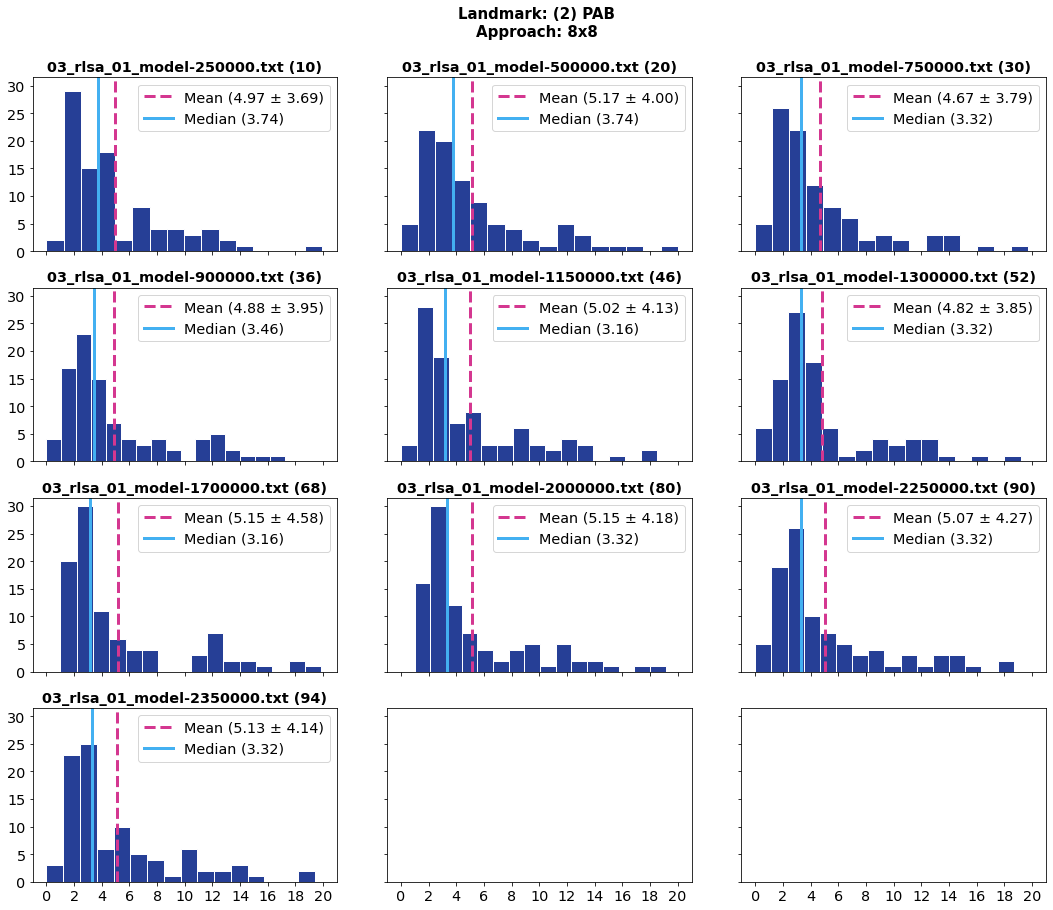

In [6]:
logs = {0:[['00_rlsa_00_model-300000.txt',
            '00_rlsa_00_model-425000.txt',
            '00_rlsa_00_model-600000.txt',
            '00_rlsa_00_model-1250000.txt',
            '00_rlsa_00_model-1600000.txt',
            '00_rlsa_00_model-1700000.txt',            
            '00_rlsa_00_model-2000000.txt', 
            '00_rlsa_00_model-2250000.txt',
            '00_rlsa_00_model-2450000.txt'],
                                 
           ['01_rlsa_00_model-250000.txt',
            '01_rlsa_00_model-500000.txt',
            '01_rlsa_00_model-1000000.txt',
            '01_rlsa_00_model-1250000.txt',
            '01_rlsa_00_model-1550000.txt',
            '01_rlsa_00_model-1800000.txt',
            '01_rlsa_00_model-2250000.txt',
            '01_rlsa_00_model-2450000.txt',
            '01_rlsa_00_model-2700000.txt',
            '01_rlsa_00_model-3200000.txt',
            '01_rlsa_00_model-4250000.txt']
           ],
         
        1:[['00_rlsa_01_model-450000.txt',
            '00_rlsa_01_model-800000.txt',
            '00_rlsa_01_model-1250000.txt',
            '00_rlsa_01_model-2600000.txt',
            '00_rlsa_01_model-3100000.txt',
            '00_rlsa_01_model-3350000.txt',
            '00_rlsa_01_model-3900000.txt',
            '00_rlsa_01_model-4350000.txt',
            '00_rlsa_01_model-4850000.txt',
            '00_rlsa_01_model-4950000.txt'], 
                     
           ['01_rlsa_01_model-250000.txt',
            '01_rlsa_01_model-500000.txt',
            '01_rlsa_01_model-650000.txt',
            '01_rlsa_01_model-1100000.txt',
            '01_rlsa_01_model-1400000.txt',
            '01_rlsa_01_model-1700000.txt',
            '01_rlsa_01_model-1800000.txt',
            '01_rlsa_01_model-2050000.txt'], 
                     
           ['02_rlsa_01_model-250000.txt',
            '02_rlsa_01_model-500000.txt',
            '02_rlsa_01_model-750000.txt',
            '02_rlsa_01_model-900000.txt',
            '02_rlsa_01_model-1300000.txt',
            '02_rlsa_01_model-1550000.txt',
            '02_rlsa_01_model-1700000.txt'],
           
           ['03_rlsa_01_model-250000.txt',
            '03_rlsa_01_model-500000.txt',
            '03_rlsa_01_model-750000.txt',
            '03_rlsa_01_model-900000.txt',
            '03_rlsa_01_model-1150000.txt',
            '03_rlsa_01_model-1300000.txt',
            '03_rlsa_01_model-1700000.txt',
            '03_rlsa_01_model-2000000.txt',
            '03_rlsa_01_model-2250000.txt',
            '03_rlsa_01_model-2350000.txt']
        ],
                   
        2:[['00_rlsa_02_model-500000.txt','00_rlsa_02_model-625000.txt','00_rlsa_02_model-700000.txt','00_rlsa_02_model-875000.txt','00_rlsa_02_model-1800000.txt','00_rlsa_02_model-2000000.txt',\
            '00_rlsa_02_model-2800000.txt','00_rlsa_02_model-3150000.txt','00_rlsa_02_model-4000000.txt','00_rlsa_02_model-4300000.txt','00_rlsa_02_model-5500000.txt']
           ],
        3:[['00_rlsa_03_model-350000.txt','00_rlsa_03_model-375000.txt','00_rlsa_03_model-450000.txt','00_rlsa_03_model-550000.txt','00_rlsa_03_model-950000.txt','00_rlsa_03_model-1800000.txt',\
            '00_rlsa_03_model-2000000.txt','00_rlsa_03_model-2900000.txt','00_rlsa_03_model-3400000.txt','00_rlsa_03_model-3450000.txt']
           ]
        }

log_names = logs[num][indx]
#log_names = [logs[num][indx][-2]] # For picking just one

columns_num = 3
height_box = int(np.ceil(len(log_names)/columns_num))
figsize = (5*columns_num,min(3*height_box,16))

fig, (axes) = plt.subplots(height_box,columns_num,sharey=True, sharex=True,figsize = figsize )
ax_hist = axes.flat
results = []
num_bins = 16

barcolor = dark_blue
medcolor= light_blue
meancolor= light_red
logs_filepath = '/content/drive/My Drive/TFM/Data_models_TFM/AORTA/Logs/'
dict_results = {}

# Reading the logs:
for it, log_name in enumerate(log_names):
  with open(logs_filepath+log_name, newline='', encoding="utf16") as f:
      lines = [line.rstrip()[len('[0531 14:24:04 @common.py:71] 1/101'):].split('q_values')[0].split(' - ')[1:4]  for line in f]

  lines = lines[33:]
  epoch_num = ((int)(log_name.split('-')[1].split('.')[0]))//25000

  results.append(pd.DataFrame(lines,columns=['ID', 'score', 'distError']))
  results[it].set_index('ID')
  results[it].score = results[it].score.apply(lambda x: x[len('score '):]).astype(float)
  results[it].distError = results[it].distError.apply(lambda x: x[len('distError '):]).astype(float)
  model_mean = results[it]['distError'].mean()
  model_std = results[it]['distError'].std()
  model_median = results[it]['distError'].median()
  model_mean_score = results[it]['score'].median()
  model_max_dist = results[it]['distError'].max() 
  dict_results[f"{epoch_num}"] = [model_mean,model_std,model_median,model_mean_score,model_max_dist]
  
  #Distribution Plot
  sns.distplot(results[it]['distError'], ax=ax_hist[it],kde=False,rug=False,norm_hist=False,bins=num_bins,
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},
               hist_kws={"histtype": "barstacked", "linewidth": 1,
                            "alpha": 1, "color": barcolor, 'edgecolor':"#FFFFFF"}).set_title( log_name + f' ({epoch_num})' ,fontweight='bold')
  ax_hist[it].axvline(model_mean, color=meancolor, linestyle='--',linewidth = 3,label= f'Mean ({model_mean:.2f} \xb1 {model_std:.2f})')
  ax_hist[it].axvline(model_median, color=medcolor, linestyle='-',linewidth = 3,label= f'Median ({model_median:.2f})')
  ax_hist[it].legend()
  ax_hist[it].set(xlabel='')

ax_hist[-1].xaxis.set_ticks(np.arange(0, ax_hist[-1].get_xlim()[1], 2))
ax_hist[-1].yaxis.set_ticks(np.arange(0, ax_hist[-1].get_ylim()[1], 5))

plt.suptitle( f"Landmark: {lm_names[num]}\nApproach: {exp_desc[num][indx]}"  ,fontweight='bold',fontsize = 15, y=1.05)
fig.tight_layout()

plt.show()

,epoch_num,mean_distance,dist_std,dist_median,mean_score,max_distance,weighted_value,cv,esp
0,10,4.9703,3.6883,3.7417,40.1930,19.8997,2031.8316,0.7421,46.1978
1,20,5.1717,4.0022,3.7417,36.6006,20.0250,1767.0721,0.7739,49.3001
2,30,4.6736,3.7900,3.3166,40.8402,19.7231,2215.3105,0.8109,40.6402
3,36,4.8825,3.9466,3.4641,42.0915,17.2337,2501.1569,0.8083,44.2564
4,46,5.0186,4.1292,3.1623,40.9130,18.4932,2204.1067,0.8228,41.9857
5,52,4.8240,3.8474,3.3166,41.1214,19.2094,2218.8104,0.7976,41.5201
6,68,5.1467,4.5773,3.1623,41.6529,19.8746,2036.0353,0.8894,45.2247
7,80,5.1476,4.1777,3.3166,41.9857,19.1311,2131.6830,0.8116,44.7843
8,90,5.0745,4.2722,3.3166,40.2570,18.6815,2123.2651,0.8419,45.1691
9,94,5.1319,4.1359,3.3166,43.1154,19.3907,2166.3796,0.8059,44.4552


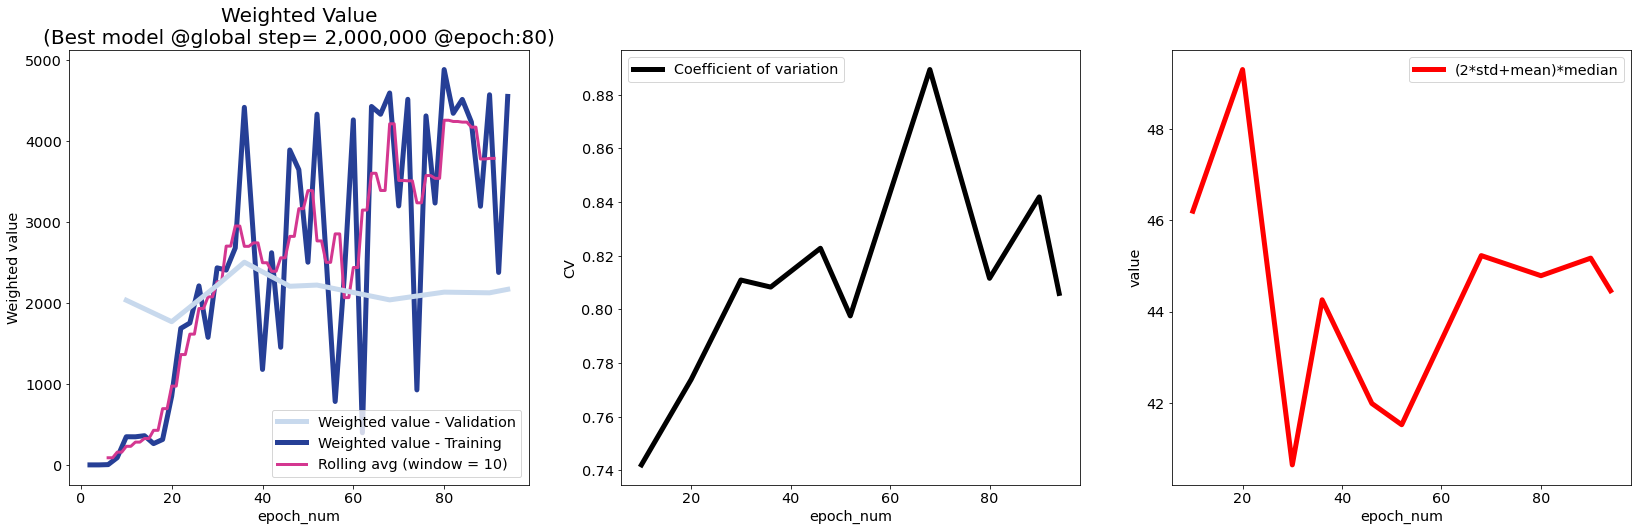

In [7]:
validation_results = pd.DataFrame.from_dict(dict_results,orient='index', columns=['mean_distance', 'dist_std','dist_median','mean_score','max_distance'])
validation_results['weighted_value'] =  validation_results.apply(lambda row: \
                                      5000*row.mean_score/((row.mean_distance)*(row.max_distance)), axis=1)
validation_results['cv'] = validation_results.apply(lambda row: (row.dist_std/row.mean_distance), axis=1)
validation_results['esp'] = validation_results.apply(lambda row: ((2*row.dist_std+row.mean_distance)*row.dist_median), axis=1)
validation_results.index.name = "epoch_num"
validation_results= validation_results.reset_index().astype({'epoch_num': 'int64'})

fig, (ax,ax_pres,ax_esp) = plt.subplots(1,3,figsize = (28,8) )
sns.lineplot(data=validation_results,x="epoch_num",y="weighted_value",ax= ax,color = lighter_blue, zorder = -3, linewidth = 5,label = f'Weighted value - Validation')
sns.lineplot(x="epoch_num", y="weighted_value", data=my_df,ax= ax,color = dark_blue, zorder = -5, linewidth = 5,label = f'Weighted value - Training')
sns.lineplot(x="epoch_num", y="rolling_w_v", data=my_df,ax= ax,
          color = light_red,linewidth = 3, zorder = -4,linestyle ='--',
          label =f'Rolling avg (window = {windowsize})').set_title(f"Weighted Value\n(Best model @global step= {best_mod.global_step:,.0f} @epoch:{best_mod.epoch_num:.0f})", fontsize=20)
ax.set(ylabel='Weighted value')


sns.lineplot(data=validation_results,x="epoch_num",y="cv",ax= ax_pres,color = 'k', zorder = -3, linewidth = 5,label = f'Coefficient of variation')
ax_pres.set(ylabel='CV')
sns.lineplot(data=validation_results,x="epoch_num",y="esp",ax= ax_esp,color = 'r', zorder = -3, linewidth = 5,label = f'(2*std+mean)*median')
ax_esp.set(ylabel='value')
validation_results

Number of landmarks beyond the threshold:  40 (43.01%)


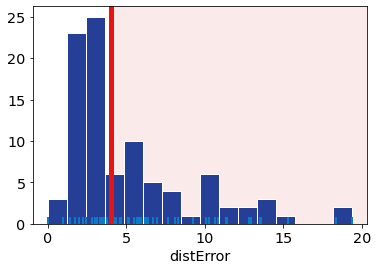

In [8]:
treshold = 4
df_num = -1

errors = results[df_num].loc[results[df_num]['distError'] > treshold,:].sort_values(by='distError',ascending = False)
hist_ax= sns.distplot(results[df_num]['distError'],kde=False,rug=True,norm_hist=False,bins=num_bins,
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},
               hist_kws={"histtype": "barstacked", "linewidth": 1,
                            "alpha": 1, "color": barcolor, 'edgecolor':"#FFFFFF"})
hist_ax.axvline(treshold,color = '#EA1313',linewidth = 5)
xlim = hist_ax.get_xlim()
hist_ax.axvspan(treshold, xlim[-1], color='#EF9A9A', alpha=0.2,zorder = -10)
hist_ax.set_xlim(xlim)

print('Number of landmarks beyond the threshold: ', errors.distError.size,f'({errors.distError.size/results[df_num].distError.size:.2%})' )

In [9]:
#errors.sort_values(by='distError',ascending=True)

## Final Results

10.307764064044152
8.660254037844386
6.123724356957945
6.123724356957945


,N,Mínimo,Máximo,Media,Desv. típ.,mean + 2*sD,mean - 2*sD
Landmark,,,,,,,
1,101,2.5,34.7311,11.3555,7.0232,-2.6908,25.4019
2,101,0.0,38.9711,11.7874,9.2245,-6.6617,30.2364
3,101,0.0,26.6927,7.0787,4.8299,-2.5811,16.7386
4,101,0.0,23.1840,7.5171,5.0797,-2.6422,17.6764


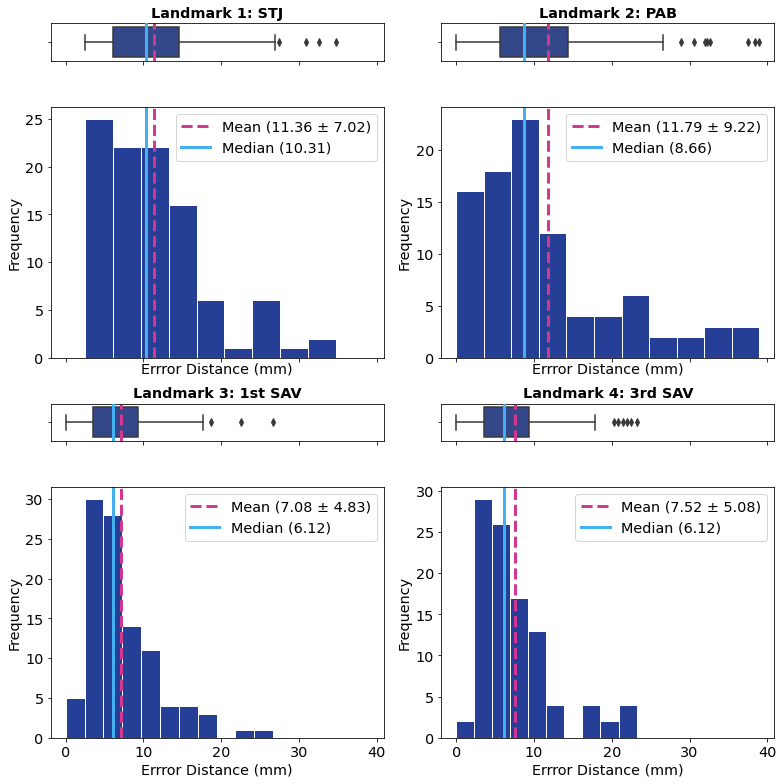

In [10]:
lm_1 = {'5x5':'00_rlsa_01_model-4350000.txt', '6x6':'01_rlsa_01_model-1700000.txt','7x7':'02_rlsa_01_model-900000.txt','8x8':'03_rlsa_01_model-750000.txt'}
lm_0 = {'7x7ms4':'00_rlsa_00_model-1600000.txt','5x5':'01_rlsa_00_model-1250000.txt'}

dict_best = {0:'01_rlsa_00_model-1250000.txt',1:'01_rlsa_01_model-1700000.txt',2:'00_rlsa_02_model-3150000.txt',3:'00_rlsa_03_model-3400000.txt'}

columns =['Landmark','N','Mínimo','Máximo','Media','Desv. típ.']
performance = pd.DataFrame(columns =columns)

fig, (axes) = plt.subplots(ncols=2, nrows=4,sharex=True, gridspec_kw= {"height_ratios": [0.15, 1,0.15, 1] },figsize = (11,11))
axes= axes.flat
results = []
barcolor = "#263f96"
medcolor= '#43B0F1'
meancolor= '#D43790'
count =0
logs_filepath = '/content/drive/My Drive/TFM/Data_models_TFM/AORTA/Logs/'

for lm_ind, log_name in dict_best.items():
  with open(logs_filepath+log_name, newline='', encoding="utf16") as f:
      lines = [line.rstrip()[len('[0531 14:24:04 @common.py:71] 1/101'):].split('q_values')[0].split(' - ')[1:4]  for line in f]

  lines = lines[33:]

  results.append(pd.DataFrame(lines,columns=['ID', 'score', 'distError']))
  results[lm_ind].set_index('ID')
  results[lm_ind].score = results[lm_ind].score.apply(lambda x: x[len('score '):]).astype(float)
  results[lm_ind].distError = results[lm_ind].distError.apply(lambda x: x[len('distError '):]).astype(float)
  results[lm_ind].distError = results[lm_ind].distError.apply(lambda x : x*2.5)
  mean = results[lm_ind]['distError'].mean()
  std = results[lm_ind]['distError'].std()  
  median=results[lm_ind]['distError'].median()
  print(median)
  max_dist = results[lm_ind]['distError'].max()
  min_dist = results[lm_ind]['distError'].min()
  to_append = pd.DataFrame( {'Landmark':[lm_ind+1],'N':[101],'Mínimo':[min_dist],'Máximo':[max_dist],'Media':[mean],'Desv. típ.':[std]})  
  performance = performance.append(to_append)
  axes[lm_ind+count].axvline(median, color=medcolor,linewidth = 3, linestyle='-',zorder = 10)
  axes[lm_ind+count].axvline(mean, color=meancolor,linewidth = 3, linestyle='--')    
  sns.boxplot(results[lm_ind]['distError'], ax=axes[lm_ind+count], color =barcolor)
  axes[lm_ind+count].set(xlabel='')
  app_ind = (int)(log_name.split('_')[0])
  title_plot = f"Landmark {lm_ind+1}: {' '.join(lm_names[lm_ind].split()[1:])}"
  #title_plot += f"\nApproach: {exp_desc[lm_ind][app_ind]}"
  axes[lm_ind+count].set_title( title_plot,fontweight='bold')

  sns.distplot(results[lm_ind]['distError'], ax=axes[lm_ind+count+2],kde=False,rug=False,norm_hist=False,\
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},
               hist_kws={"histtype": "barstacked", "linewidth": 1,
                            "alpha": 1, "color": barcolor, 'edgecolor':"#FFFFFF"})
  axes[lm_ind+count+2].set(xlabel='Errror Distance (mm)', ylabel='Frequency')
  axes[lm_ind+count+2].axvline(mean, color=meancolor, linestyle='--',linewidth = 3,label= f'Mean ({mean:.2f} \xb1 {std:.2f})')
  axes[lm_ind+count+2].axvline(median, color=medcolor, linestyle='-',linewidth = 3,label= f'Median ({median:.2f})')
  axes[lm_ind+count+2].legend()
  count += 2*(lm_ind%2)

fig.tight_layout()

#Compute table values
def f1(x):
  return x[4] + 2*x[5] 
def f2(x):
  return x[4] - 2*x[5]
performance['mean + 2*sD'] = performance.apply(f2 , axis=1)
performance['mean - 2*sD'] = performance.apply(f1 , axis=1)
performance.set_index('Landmark', inplace=True)
performance

In [11]:
distance_1 = '/content/drive/My Drive/TFM/Data_models_TFM/AORTA/distance_lm1.txt'
distance_2 = '/content/drive/My Drive/TFM/Data_models_TFM/AORTA/distance_lm2.txt'
distance_3 = '/content/drive/My Drive/TFM/Data_models_TFM/AORTA/distance_lm3.txt'
distance_4 = '/content/drive/My Drive/TFM/Data_models_TFM/AORTA/distance_lm4.txt'

d1_df = pd.read_csv(distance_1, sep=" - ", header=None,engine='python')
d1_df.columns = ["name", "score", "disterror", "final_loc"]
d1_df = d1_df.loc[:,["name","disterror"]]
d1_df["landmark"] = '(1) STJ'
d1_df["Source"] = 'RL Agent'

d2_df = pd.read_csv(distance_2, sep=" - ", header=None,engine='python')
d2_df.columns = ["name", "score", "disterror", "final_loc"]
d2_df = d2_df.loc[:,["name","disterror"]]
d2_df["landmark"] = '(2) PAB'
d2_df["Source"] =  'RL Agent'

d3_df = pd.read_csv(distance_3, sep=" - ", header=None,engine='python')
d3_df.columns = ["name", "score", "disterror", "final_loc"]
d3_df = d3_df.loc[:,["name","disterror"]]
d3_df["landmark"] = '(3) 1st SAV'
d3_df["Source"] =  'RL Agent'

d4_df = pd.read_csv(distance_4, sep=" - ", header=None,engine='python')
d4_df.columns = ["name", "score", "disterror", "final_loc"]
d4_df = d4_df.loc[:,["name","disterror"]]
d4_df["landmark"] = '(4) 3rd SAV'
d4_df["Source"] =  'RL Agent'

our_distances = pd.concat([d1_df, d2_df,d3_df,d4_df], ignore_index=True)
our_distances["disterror"] = our_distances["disterror"].apply(lambda x: x*2.5)

distances_route = '/content/drive/My Drive/TFM/Data_models_TFM/AORTA/distances.csv'
df_human = pd.read_csv(distances_route)
df_human.columns = ["name", "disterror1", "disterror2", "disterror3", "disterror4"]


hu_d1 = df_human.loc[:,["name","disterror1"]]
hu_d1.columns = ["name","disterror"]
hu_d1["landmark"] = '(1) STJ'
hu_d1["Source"] = 'Human'

hu_d2 = df_human.loc[:,["name","disterror2"]]
hu_d2.columns = ["name","disterror"]
hu_d2["landmark"] = '(2) PAB'
hu_d2["Source"] = 'Human'

hu_d3 = df_human.loc[:,["name","disterror3"]]
hu_d3.columns = ["name","disterror"]
hu_d3["landmark"] = '(3) 1st SAV'
hu_d3["Source"] = 'Human'

hu_d4 = df_human.loc[:,["name","disterror4"]]
hu_d4.columns = ["name","disterror"]
hu_d4["landmark"] = '(4) 3rd SAV'
hu_d4["Source"] = 'Human'

their_distances = pd.concat([hu_d1, hu_d2,hu_d3,hu_d4], ignore_index=True)

all_distances = pd.concat([our_distances, their_distances], ignore_index=True)

all_distances.columns = ["Name","Disterror",'Landmark', 'Source']

result_table = all_distances.groupby(['Landmark', 'Source']).agg(['median','mean', 'std'])
result_table

# df_A = hu_d4.copy()
# df_B = d4_df.copy()
# df_B["disterror"] = df_B["disterror"].apply(lambda x: x*2.5)
# pd.concat([df_A, df_B],ignore_index=True).to_csv('lm_1.csv')
# from google.colab import files
# files.download("lm_1.csv")

Disterror                 
                        median     mean     std
Landmark    Source                             
(1) STJ     Human       8.0823  11.0112  8.7860
            RL Agent    8.8375   9.8450  6.2577
(2) PAB     Human       7.0363  10.2398  8.2183
            RL Agent   11.5875  14.2150  9.0483
(3) 1st SAV Human       3.8541   6.6496  6.8472
            RL Agent    5.6000   6.3000  3.7560
(4) 3rd SAV Human       3.9727   6.8051  6.5999
            RL Agent    6.6000   7.0467  4.6028

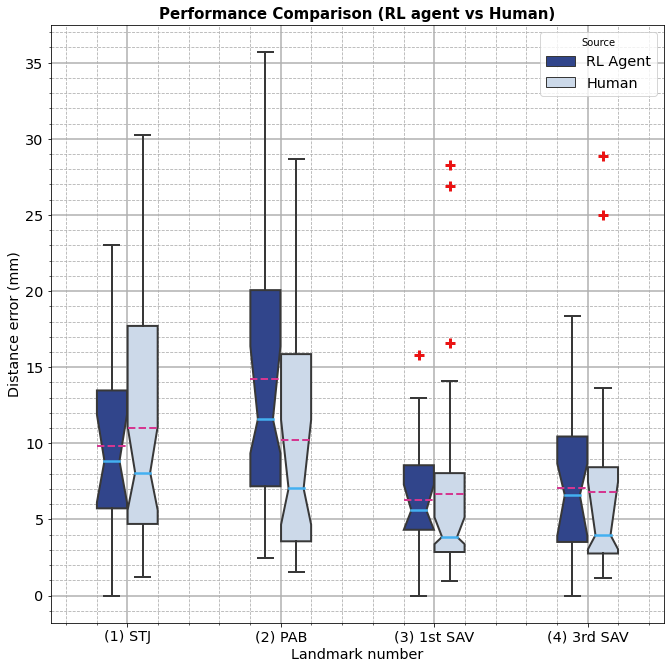

In [17]:
colors = [dark_blue ,lighter_blue, light_orange ,light_blue,lighter_blue ,light_red,red]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

medianprops = dict(linestyle='-', linewidth=2.5, color=light_blue)
meanlineprops = dict(linestyle='--', linewidth=2, color=light_red)
flierprops = dict(marker='+', markerfacecolor= light_red, markersize= 10,mec = red, markeredgewidth=3)

plt.figure(figsize = (11,11))
ax = sns.boxplot(x="Landmark", y="Disterror", hue="Source", data=all_distances,
                 linewidth=2,saturation =.8, width =.4,fliersize = 5,meanline=True,
                 flierprops=flierprops, notch=True,bootstrap = 5000,
                 showmeans=True, meanprops=meanlineprops,medianprops=medianprops)

ax.set_xlabel('Landmark number')
ax.set_ylabel('Distance error (mm)')

ax.grid(b=True, which='major', linestyle='-',linewidth = 1.5)
ax.grid(b=True, which='minor', linestyle='--')
ax.set_axisbelow(True)
ax.set_title( f"Performance Comparison (RL agent vs Human)"  ,fontweight='bold',fontsize = 15)
plt.minorticks_on()

<IPython.core.display.Javascript object>

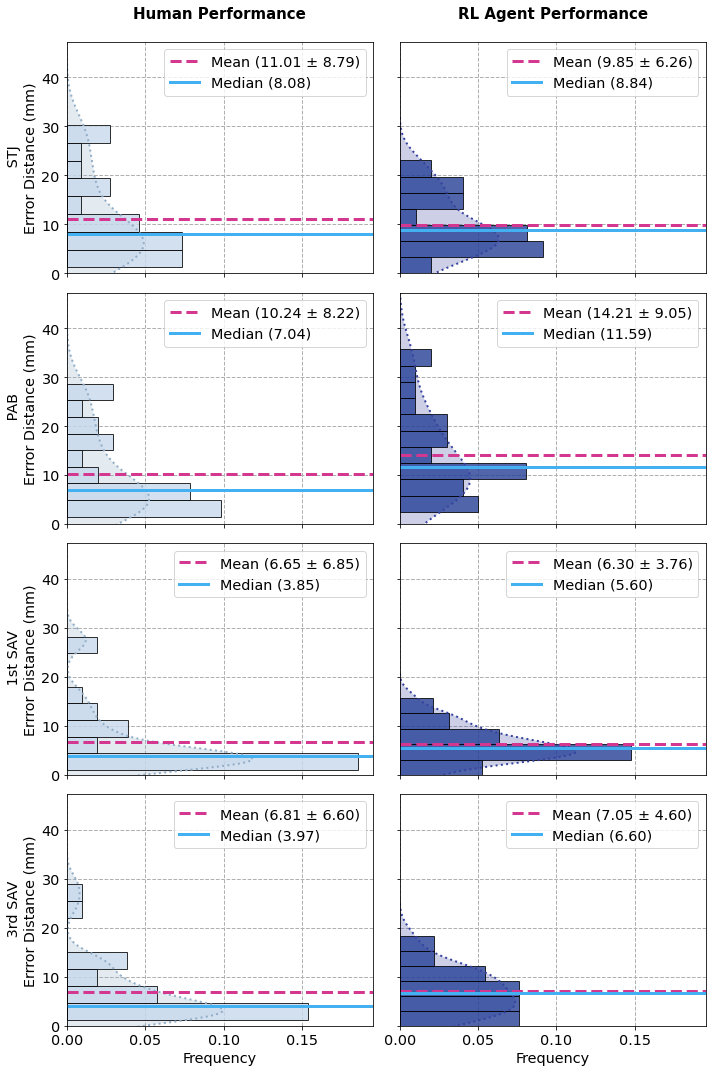

In [15]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
colors = [lighter_blue, dark_blue ,light_blue, dark_blue,light_orange ,light_red,red]

landmark_names = ["(1) STJ", "(2) PAB"	,"(3) 1st SAV","(4) 3rd SAV"]
bin_value = [8,7,
             8,10,
             8,5,
             8,6]
fig, (axes) = plt.subplots(ncols=2, nrows=4,sharex=True,sharey=True, gridspec_kw= {"height_ratios": [1, 1,1, 1] },figsize = (10,15))
axes= axes.flat
count =0

for lm_ind, lm_name in enumerate(landmark_names):

  medianprops = dict(linestyle='-', linewidth=2.5, color=light_blue)
  meanlineprops = dict(linestyle='--', linewidth=2, color=light_red)
  flierprops = dict(marker='+', markerfacecolor= light_red, markersize= 10,mec = red, markeredgewidth=3)  
  
  current_df = all_distances.loc[all_distances["Landmark"] == lm_name]  

  for ind, source in enumerate(['Human','RL Agent']):
    source_df = current_df.loc[current_df["Source"] == source]
    median_ ,mean_ ,std_ = result_table.loc[(lm_name,source)]

    mycolor = "#36429e" if ind == 1 else '#93aec7'
    sns.distplot(source_df["Disterror"], ax=axes[lm_ind*2+ind],kde=True,rug=False,norm_hist=False,bins=bin_value[lm_ind*2+ind],
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},vertical=True,
               kde_kws={"color": mycolor , "lw": 2,"linestyle" : ':',"shade": True},
               hist_kws={"histtype": "barstacked", "linewidth": 1,"alpha": 0.8, "color": colors[ind], 'edgecolor':'k'})
    if (lm_ind*2+ind) %2 == 0: 
      axes[lm_ind*2+ind].set(ylabel=f'{lm_name[3:]}\nErrror Distance (mm)',xlabel = '')
    else:
      axes[lm_ind*2+ind].set(ylabel='',xlabel = '')

    axes[lm_ind*2+ind].axhline(mean_, color=light_red, linestyle='--',linewidth = 3,label= f'Mean ({mean_:.2f} \xb1 {std_:.2f})')
    axes[lm_ind*2+ind].axhline(median_, color=light_blue, linestyle='-',linewidth = 3,label= f'Median ({median_:.2f})')
    axes[lm_ind*2+ind].legend()
    axes[lm_ind*2+ind].set(ylim=(0, None))
    axes[lm_ind*2+ind].grid(b=True, which='major', linestyle='--',linewidth = 1)
    
    axes[lm_ind*2+ind].set_axisbelow(True)

#[ax.set(xlabel='Frequency') for ax in axes[0:2]]
[ax.set(xlabel='Frequency') for ax in axes[-2:]]
# [ax.tick_params(top=True,labeltop = True) for ax in axes[0:2]]
# [ax.tick_params(bottom=False,labelbottom = False) for ax in axes[-2:]]
# [ax.xaxis.set_label_position('top') for ax in axes[0:2]]

axes[0].set_axisbelow
axes[0].set_title( "Human Performance\n"  ,fontweight='bold',fontsize = 15)

axes[1].set_title( "RL Agent Performance\n"  ,fontweight='bold',fontsize = 15)

fig.tight_layout()

<IPython.core.display.Javascript object>

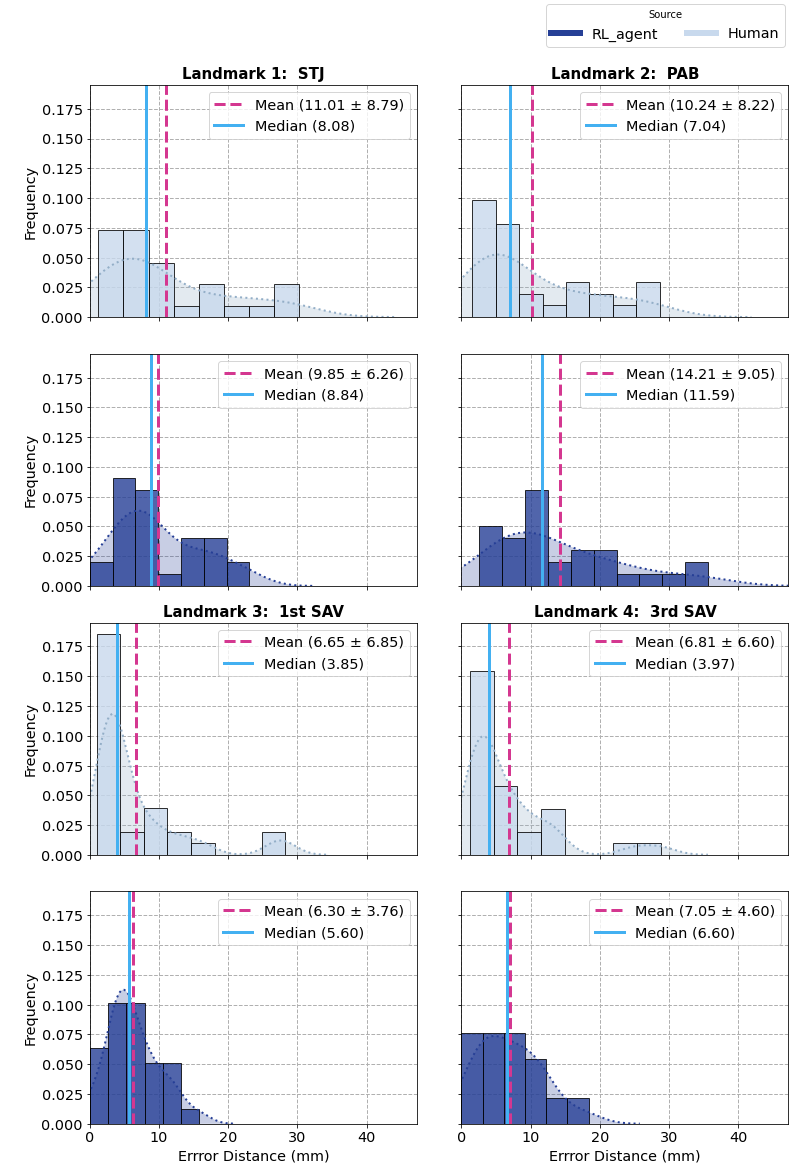

In [16]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
colors = [lighter_blue, dark_blue ,light_blue, dark_blue,light_orange ,light_red,red]

landmark_names = ["(1) STJ", "(2) PAB"	,"(3) 1st SAV","(4) 3rd SAV"]
bin_value = [8,8,
             7,10,
             8,8,
             6,6]             
fig, (axes) = plt.subplots(ncols=2, nrows=4,sharex=True,sharey=True, gridspec_kw= {"height_ratios": [0.9, 0.9,0.9, 0.9] },figsize = (11,15.5))
axes= axes.flat
count =0

for lm_ind, lm_name in enumerate(landmark_names):

  medianprops = dict(linestyle='-', linewidth=2.5, color=light_blue)
  meanlineprops = dict(linestyle='--', linewidth=2, color=light_red)
  flierprops = dict(marker='+', markerfacecolor= light_red, markersize= 10,mec = red, markeredgewidth=3)  
  current_df = all_distances.loc[all_distances["Landmark"] == lm_name] 

  axes[lm_ind+count].set_title( f"Landmark {lm_ind+1}: {lm_name[3:]}"  ,fontweight='bold',fontsize = 15)

  for ind, (off_ind, source) in enumerate(zip([0,2],['Human','RL Agent'])):
    source_df = current_df.loc[current_df["Source"] == source]
    median_ ,mean_ ,std_ = result_table.loc[(lm_name,source)]
    #print(lm_ind+count+off_ind)
    mycolor = dark_blue if ind == 1 else '#93aec7'
    sns.distplot(source_df["Disterror"], ax=axes[lm_ind+count+off_ind],kde=True,rug=False,norm_hist=False,bins=bin_value[lm_ind+count+off_ind],
               rug_kws={"color": "#057DCD","linewidth": 2,"height":0.03},vertical=False,
               kde_kws={"color": mycolor , "lw": 2,"linestyle" : ':',"shade": True},
               hist_kws={"histtype": "barstacked", "linewidth": 1,"alpha": 0.8, "color": colors[ind], 'edgecolor':'k'})
    
    if (lm_ind+count+off_ind) %2 == 0: 
      axes[lm_ind+count+off_ind].set(ylabel=f'\nFrequency',xlabel = '')
    else:
      axes[lm_ind+count+off_ind].set(ylabel='',xlabel = '')

    axes[lm_ind+count+off_ind].axvline(mean_, color=light_red, linestyle='--',linewidth = 3,label= f'Mean ({mean_:.2f} \xb1 {std_:.2f})')
    axes[lm_ind+count+off_ind].axvline(median_, color=light_blue, linestyle='-',linewidth = 3,label= f'Median ({median_:.2f})')
    axes[lm_ind+count+off_ind].legend()
    axes[lm_ind+count+off_ind].set(xlim=(0, None))
    axes[lm_ind+count+off_ind].grid(b=True, which='major', linestyle='--',linewidth = 1)
    
    axes[lm_ind + count +off_ind].set_axisbelow(True)
  count += 2*(lm_ind%2)

[ax.set(xlabel='Errror Distance (mm)') for ax in axes[-2:]]


legend_elements = [Line2D([0], [0], color=dark_blue, lw=6, label='RL_agent'),
                   Line2D([0], [0], color=lighter_blue, lw=6, label='Human')]

fig.legend( bbox_to_anchor=(1 ,1) , handles=legend_elements, loc='lower right',title="Source",ncol= 2);
fig.tight_layout(pad=1, h_pad=None, w_pad=4, rect=None)
